In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!nvidia-smi

Thu Mar 19 01:51:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 5590 (delta 15), reused 18 (delta 6), pack-reused 5557
Receiving objects: 100% (5590/5590), 13.35 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (3741/3741), done.


In [4]:
!pip install --upgrade keras

     |████████████████████████████████| 378kB 9.3MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [5]:
%cd /content/keras-retinanet

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170517 sha256=44bda22ebfcf7602559ffbba7aa4d228101db5ea70212b85c7f7d4e472f9a5ea
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=824c07567024cb8659c173344fe8117a8f11c274463ff40447146ea962969410
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [6]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [7]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 41kB/s 


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 72.0MB/s]


In [0]:
os.makedirs("snapshots", exist_ok=True)

In [12]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:02, 105MB/s] 


In [0]:
plates_df = pd.read_json('indian_number_plates.json', lines=True)

In [14]:
plates_df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [0]:
os.makedirs("number_plates", exist_ok=True)

In [17]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in plates_df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")
    
    dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')
    
    data = row["annotation"]
  
    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
    dataset["class_name"].append("license_plate")
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [18]:
df = pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,number_plates/licensed_car_0.jpeg,582,274,700,321,license_plate
1,number_plates/licensed_car_1.jpeg,80,382,288,449,license_plate
2,number_plates/licensed_car_2.jpeg,41,219,115,260,license_plate
3,number_plates/licensed_car_3.jpeg,217,313,359,359,license_plate
4,number_plates/licensed_car_4.jpeg,209,220,866,554,license_plate


In [19]:
df.iloc[0]

image_name    number_plates/licensed_car_0.jpeg
x_min                                       582
y_min                                       274
x_max                                       700
y_max                                       321
class_name                        license_plate
Name: 0, dtype: object

In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

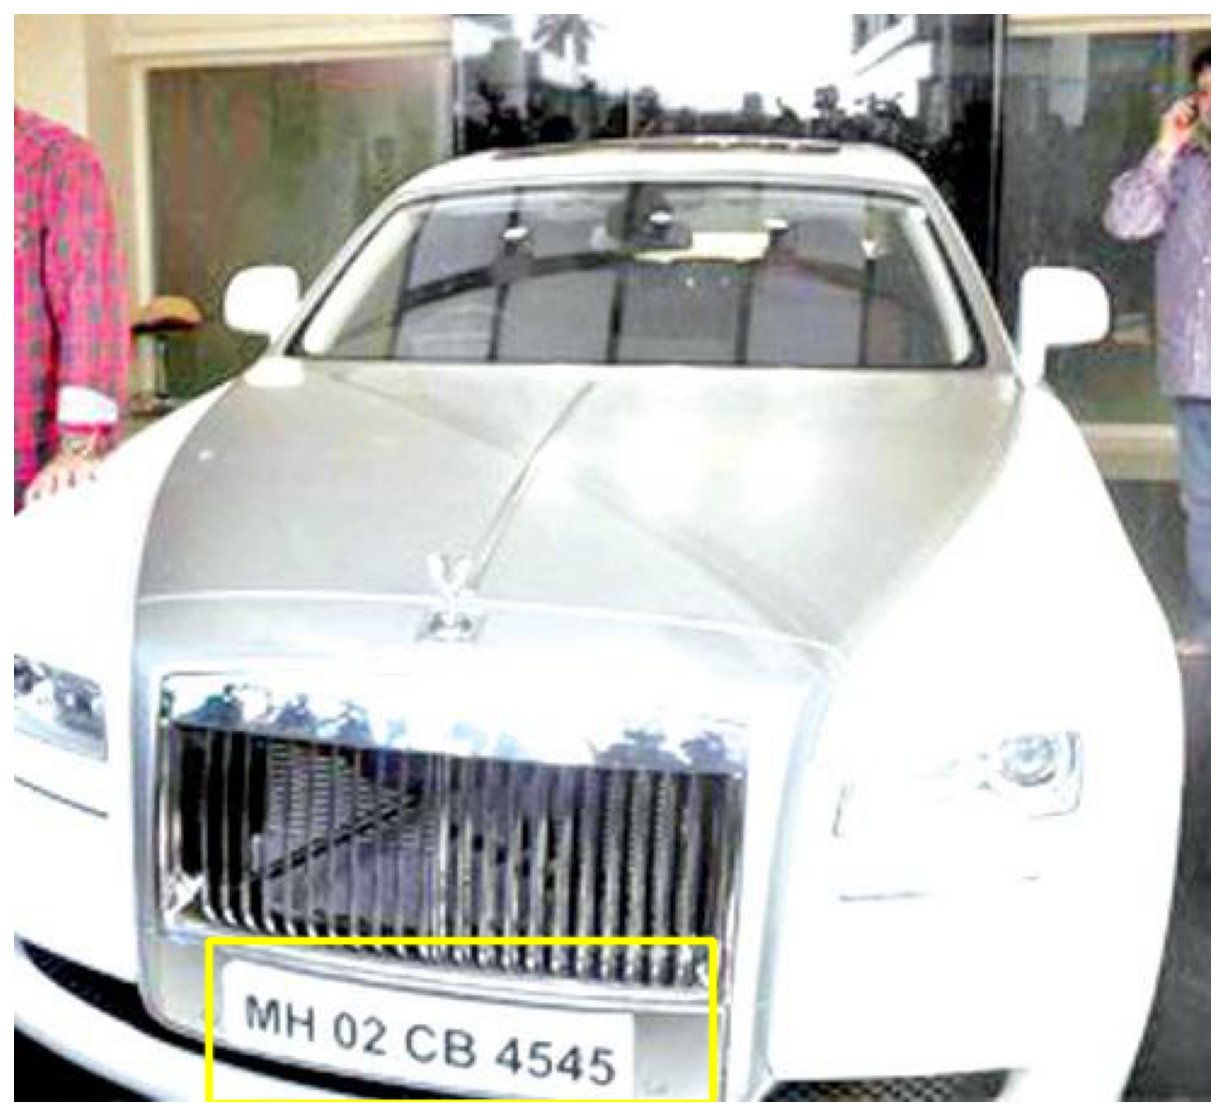

In [22]:
show_image_objects(df.iloc[1])

In [0]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [25]:
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
183,number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate
201,number_plates/licensed_car_201.jpeg,251,187,375,234,license_plate
230,number_plates/licensed_car_230.jpeg,140,149,324,220,license_plate
95,number_plates/licensed_car_95.jpeg,302,420,671,534,license_plate
190,number_plates/licensed_car_190.jpeg,115,86,227,117,license_plate


In [0]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [27]:
!pwd

/content/keras-retinanet


In [0]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [0]:
classes = set(['license_plate'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [30]:
!head annotations.csv

number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate
number_plates/licensed_car_201.jpeg,251,187,375,234,license_plate
number_plates/licensed_car_230.jpeg,140,149,324,220,license_plate
number_plates/licensed_car_95.jpeg,302,420,671,534,license_plate
number_plates/licensed_car_190.jpeg,115,86,227,117,license_plate
number_plates/licensed_car_84.jpeg,103,209,258,276,license_plate
number_plates/licensed_car_158.jpeg,83,34,369,483,license_plate
number_plates/licensed_car_97.jpeg,123,117,221,170,license_plate
number_plates/licensed_car_147.jpeg,162,227,312,274,license_plate
number_plates/licensed_car_184.jpeg,100,148,259,208,license_plate


In [31]:
!head classes.csv

license_plate,0


In [32]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [0]:
!keras_retinanet/bin/train.py \
  --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 500 \
  --epochs 10 \
  csv annotations.csv classes.csv

Using TensorFlow backend.
2020-03-19 02:25:25.148498: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-03-19 02:25:25.148626: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-03-19 02:25:25.148647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Creating model, this may take a second...
2020-03-19 02:25:26.238971: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORC